In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
#import tensorflow_hub as hub
#import tensorflow_text as text

print("TF Version: ", tf.__version__)

c:\Users\mgf-l\Documents\University\GitHub\fb_event_scraper\cat_pred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TF Version:  2.16.1


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_loc = "C:\\Users\\mgf-l\\Desktop\\structured_data.xlsx"
df = pd.read_excel(data_loc)
    
df = df.dropna(subset=['category', 'title'])


df = df[['category', 'title']]


X = df['title']   
y = df['category']  


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) 

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))
train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Library'
label:  b'Other'


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_X)  # Fit only to training data

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences
max_length = max(len(x) for x in train_sequences)  # You can set a specific max_length if you prefer
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')


In [6]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import pickle

encoder = LabelEncoder()
encoder.fit(train_y) 

with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)
 # Fit encoder on the training labels

# Transform categories to integers
train_labels = encoder.transform(train_y)
test_labels = encoder.transform(test_y)

# Convert to one-hot encoding
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels)


In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  b'Lib'

labels:  b'Oth'


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



c:\Users\mgf-l\Documents\University\GitHub\fb_event_scraper\cat_pred\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
history = model.fit(train_padded, train_labels_one_hot, epochs=20, validation_data=(test_padded, test_labels_one_hot))


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9778 - loss: 0.1104 - val_accuracy: 0.9386 - val_loss: 0.2170
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9779 - loss: 0.1042 - val_accuracy: 0.9386 - val_loss: 0.2108
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9675 - loss: 0.1192 - val_accuracy: 0.9420 - val_loss: 0.2090
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9670 - loss: 0.1272 - val_accuracy: 0.9386 - val_loss: 0.2052
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.1092 - val_accuracy: 0.9420 - val_loss: 0.2039
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9790 - loss: 0.0956 - val_accuracy: 0.9420 - val_loss: 0.1999
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0939 - val_accuracy: 0.9420 - val_loss: 0.2008
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 0.0893 - val_accuracy: 0.9386 - val_loss:

In [10]:
loss, accuracy = model.evaluate(test_padded, test_labels_one_hot)
print(f"Test accuracy: {accuracy}")


predictions = model.predict(test_padded)
predicted_categories = encoder.inverse_transform([np.argmax(p) for p in predictions])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.2251 
Test accuracy: 0.9419795274734497
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [11]:


scrape_df = pd.read_excel("C:\\Users\\mgf-l\\Desktop\\structured_data.xlsx", sheet_name="scraped_raw")

scrape_titles = scrape_df['title']

scrape_sequences = tokenizer.texts_to_sequences(scrape_titles)
scrape_padded = pad_sequences(scrape_sequences, maxlen=max_length, padding='post')

scrape_predictions = model.predict(scrape_padded)
scrape_predicted_categories = encoder.inverse_transform([np.argmax(p) for p in scrape_predictions])



scrape_df['Predicted Category'] = scrape_predicted_categories

scrape_df.to_excel("C:\\Users\\mgf-l\\Desktop\\title_prediction_output.xlsx", sheet_name="scraped_results", index=False)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 16)          │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,126 (1.84 MB)

 Trainable params: 160,708 (627.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 321,418 (1.23 MB)

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")



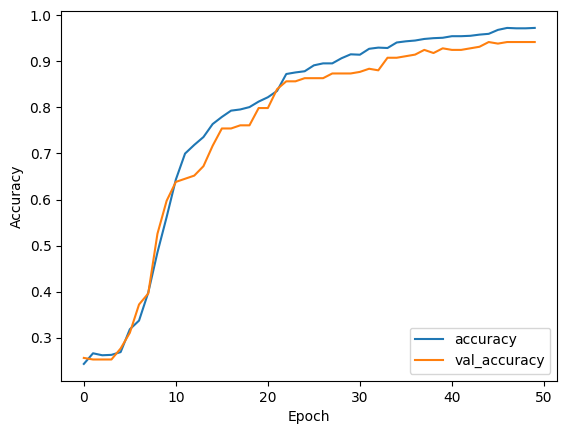

In [12]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

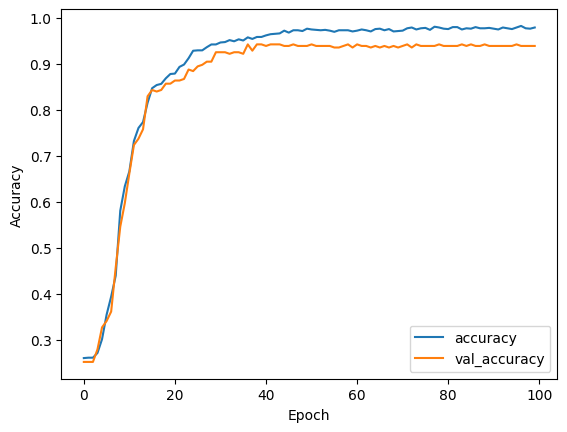

In [21]:


plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

##Way too overfitted, need to reduce the number of epochs


In [15]:
model.save("title_prediction_model.h5")